In [1]:
import pandas as pd
import numpy as np

### Preview and Load Data

In [2]:
work_forecast = pd.read_csv("work_forecast.csv")
display(work_forecast.head())
work_hist = pd.read_csv("workerhist.csv")
display(work_hist.head())


,Date,Work_type,Farm,Work Requirement
0,2025-01-24,Harvest,Central,1388.41000
1,2025-01-24,Harvest,East,17657.46000
2,2025-01-24,Harvest,North,4709.35000
3,2025-01-24,Harvest,South,25071.00000
4,2025-01-24,Planting,Central,41.79997


,Unnamed: 0,Date,Worker_id,Performance,Work_type,North_Farm_Distance,South_Farm_Distance,East_Farm_Distance,West_Farm_Distance,Central_Farm_Distance
0,0,2023-12-01 00:00:00.000,75938377,420,Pruning,4508.0,34.0,33.0,6.0,28.0
1,1,2023-12-01 00:00:00.000,48337975,270,Pruning,4506.0,37.0,35.0,9.0,30.0
2,2,2023-12-01 00:00:00.000,75554289,270,Pruning,4504.0,36.0,35.0,9.0,29.0
3,3,2023-12-01 00:00:00.000,32223030,1125,Pruning,4502.0,8.0,6.0,21.0,1.0
4,4,2023-12-01 00:00:00.000,46640655,1560,Pruning,4490.0,30.0,29.0,18.0,21.0


In [3]:
#Forecast only contains harvest, planting and pruning
print(work_forecast["Work_type"].unique())
#History has forecast work, but also Packing
print(work_hist["Work_type"].unique())


['Harvest' 'Planting' 'Pruning']
['Pruning' 'Harvest' 'Packing' 'Planting']


In [4]:
#checking any missing data points, looks like we are all good
print(work_forecast.isnull().sum())
print(work_hist.isnull().sum())

Date                0
Work_type           0
Farm                0
Work Requirement    0
dtype: int64
Unnamed: 0               0
Date                     0
Worker_id                0
Performance              0
Work_type                0
North_Farm_Distance      0
South_Farm_Distance      0
East_Farm_Distance       0
West_Farm_Distance       0
Central_Farm_Distance    0
dtype: int64


## Extracting past data and aggregating to find average performance of each worker for each task

In [5]:
work_hist['Work_type'] = work_hist['Work_type'].astype('category')

# Calculate the average performance and distances
worker_avg = work_hist.groupby(['Worker_id', 'Work_type']).agg(
    Performance=('Performance', 'mean'),
    North_Farm_Distance=('North_Farm_Distance', 'mean'),
    South_Farm_Distance=('South_Farm_Distance', 'mean'),
    East_Farm_Distance=('East_Farm_Distance', 'mean'),
    West_Farm_Distance=('West_Farm_Distance', 'mean'),
    Central_Farm_Distance=('Central_Farm_Distance', 'mean')
).reset_index()

worker_avg = worker_avg.dropna()
# Display the resulting worker_avg DataFrame
display(worker_avg.head(5))

/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/ipykernel_12706/2061411546.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worker_avg = work_hist.groupby(['Worker_id', 'Work_type']).agg(


,Worker_id,Work_type,Performance,North_Farm_Distance,South_Farm_Distance,East_Farm_Distance,West_Farm_Distance,Central_Farm_Distance
0,114046,Harvest,24.163265,4500.306122,55.938776,54.387755,33.326531,49.408163
4,124986,Harvest,28.232323,4501.636364,37.616162,35.707071,32.282828,34.666667
8,188278,Harvest,16.700000,4499.600000,45.700000,44.300000,33.800000,41.700000
12,208950,Harvest,24.462366,4478.505376,32.838710,33.795699,54.172043,33.989247
16,225114,Harvest,21.250000,4571.000000,114.375000,115.750000,137.625000,123.375000


In [6]:
# narrow down my dataset because forecast doesnt require packing and if there is 0 performance, they are  not needed
worker_avg = worker_avg[worker_avg['Work_type'] != 'Packing']
worker_avg = worker_avg[worker_avg['Performance'] != 0]

In [7]:
print(worker_avg["Work_type"].unique())
print(len(worker_avg))
# chunks left us with multiple workerid and work-type that was the same
display(worker_avg[worker_avg["Worker_id"] == 124986])

['Harvest', 'Planting', 'Pruning']
Categories (4, object): ['Harvest', 'Packing', 'Planting', 'Pruning']
39722


,Worker_id,Work_type,Performance,North_Farm_Distance,South_Farm_Distance,East_Farm_Distance,West_Farm_Distance,Central_Farm_Distance
4,124986,Harvest,28.232323,4501.636364,37.616162,35.707071,32.282828,34.666667


## Visualize fluctuation in Productivity

Average Variance (Max-Min): 163.03210235892848
Average Variance (Max-Avg): 101.94751499764291
Average Variance (Avg-Min): 61.08458736128558


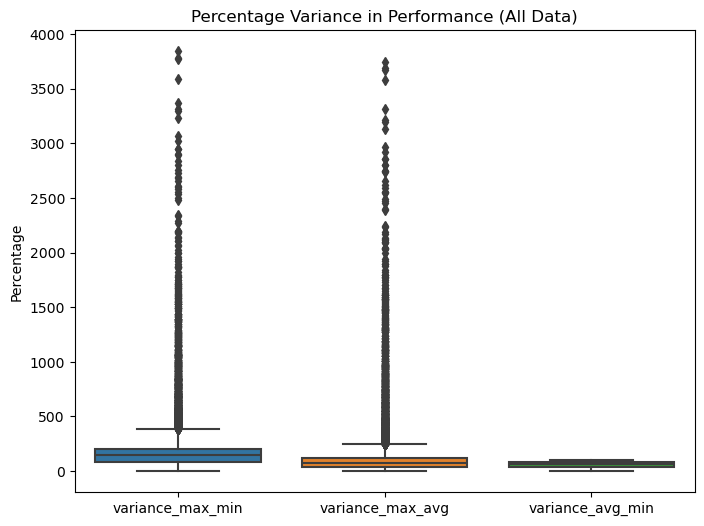

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
worker_stats = work_hist.groupby('Worker_id')['Performance'].agg(['min', 'max', 'mean'])

# Calculate percentage variance
worker_stats['variance_max_min'] = ((worker_stats['max'] - worker_stats['min']) / worker_stats['mean']) * 100
worker_stats['variance_max_avg'] = ((worker_stats['max'] - worker_stats['mean']) / worker_stats['mean']) * 100
worker_stats['variance_avg_min'] = ((worker_stats['mean'] - worker_stats['min']) / worker_stats['mean']) * 100

# Calculate the average percentage variance across all workers
avg_variance_max_min = worker_stats['variance_max_min'].mean()
avg_variance_max_avg = worker_stats['variance_max_avg'].mean()
avg_variance_avg_min = worker_stats['variance_avg_min'].mean()

print(f"Average Variance (Max-Min): {avg_variance_max_min}")
print(f"Average Variance (Max-Avg): {avg_variance_max_avg}")
print(f"Average Variance (Avg-Min): {avg_variance_avg_min}")

plt.figure(figsize=(8, 6))
sns.boxplot(data=worker_stats[['variance_max_min', 'variance_max_avg', 'variance_avg_min']])
plt.title('Percentage Variance in Performance (All Data)')
plt.ylabel('Percentage')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


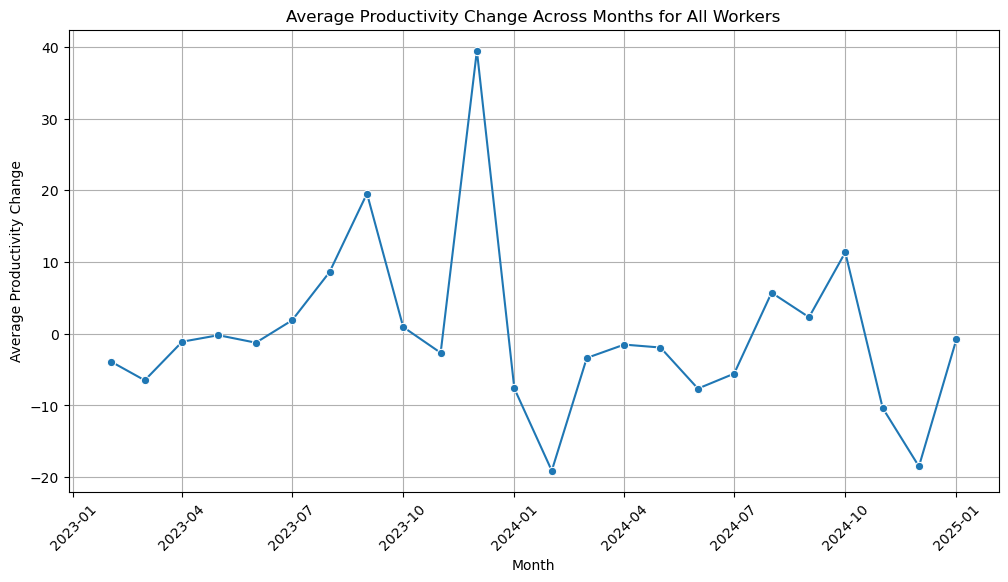

In [9]:
work_hist['Date'] = pd.to_datetime(work_hist['Date'])
work_hist['Month'] = work_hist['Date'].dt.to_period('M')

monthly_avg_productivity = work_hist.groupby(['Worker_id', 'Month'])['Performance'].mean().reset_index()
monthly_avg_productivity['Prev_Month_Performance'] = monthly_avg_productivity.groupby('Worker_id')['Performance'].shift(1)
monthly_avg_productivity['Productivity_Change'] = monthly_avg_productivity['Performance'] - monthly_avg_productivity['Prev_Month_Performance']
monthly_avg_productivity = monthly_avg_productivity.dropna(subset=['Productivity_Change'])

overall_monthly_change = monthly_avg_productivity.groupby('Month')['Productivity_Change'].mean().reset_index()

overall_monthly_change['Month'] = overall_monthly_change['Month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=overall_monthly_change, x='Month', y='Productivity_Change', marker='o')
plt.title('Average Productivity Change Across Months for All Workers')
plt.xlabel('Month')
plt.ylabel('Average Productivity Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Creating the model

In [10]:
import pulp

In [ ]:
#lambda weight to tune the model. See how much distance should have on the final result
lamda_x = 0.1
for farm in ['North', 'South', 'East', 'West', 'Central']:
    distance_col = f"{farm}_Farm_Distance"
    worker_avg[f'Weighted_Score_{farm}'] = worker_avg['Performance'] - lamda_x * worker_avg[distance_col]


In [12]:
#unique_dates = ["2025-01-27"]
unique_dates = work_forecast['Date'].unique()
all_assignments = []
all_results = []
for specific_date in unique_dates:
    print(f"Processing date: {specific_date}")
    
    # New pulp problem for this date
    model = pulp.LpProblem("Worker_Assignment", pulp.LpMinimize)
    
    # Decision variables
    all_X = {}  # Dictionary for decision variables
    
    # Filter work_forecast for the specific date
    filtered_forecast = work_forecast[work_forecast['Date'] == specific_date]
    
    # Create performance sum variables for each task
    task_performance = {}
    for index, farm in filtered_forecast.iterrows():
        work_type = farm['Work_type']
        farm_location = farm['Farm']
        required_work = farm['Work Requirement']
        
        task_key = (farm_location, specific_date, work_type)
        task_performance[task_key] = []
        
        # Filter workers by work type
        worker_work_type = worker_avg[worker_avg['Work_type'] == work_type]
        
        # Create decision variables for each worker
        for _, worker in worker_work_type.iterrows():
            key = (worker['Worker_id'], farm_location, specific_date, work_type)
            var_name = f"X_{worker['Worker_id']}_{farm_location}_{specific_date}_{work_type}"
            all_X[key] = pulp.LpVariable(var_name, cat=pulp.LpBinary)
            task_performance[task_key].append((key, worker['Performance']))
    
    # Minimize the total number of workers used
    model += pulp.lpSum(all_X.values())
    
    # need required work performances per farm
    for task_key, worker_perf_list in task_performance.items():
        farm_location, date, work_type = task_key
        required_work = filtered_forecast[(filtered_forecast['Farm'] == farm_location) & (filtered_forecast['Work_type'] == work_type)]['Work Requirement'].values[0]
        
        # Work must meet or exceed requirement
        model += pulp.lpSum(all_X[key] * perf for key, perf in worker_perf_list) >= required_work, f"MinReq_{farm_location}_{date}_{work_type}"
        
        #upperbound so we dont over assign
        model += pulp.lpSum(all_X[key] * perf for key, perf in worker_perf_list) <= required_work * 1.2, f"MaxReq_{farm_location}_{date}_{work_type}"
    
    # Ensure workers only work once a day
    for worker_id in worker_avg['Worker_id'].unique():
        daily_assignments = [all_X[key] for key in all_X if key[0] == worker_id and key[2] == specific_date]
        
        if daily_assignments:
            model += pulp.lpSum(daily_assignments) <= 1, f"OneDailyWork_{worker_id}_{specific_date}"
    
    #maximize weights performance/distance balance
    weighted_score_term = pulp.lpSum(all_X[key] * worker_avg.loc[worker_avg['Worker_id'] == key[0], 
                                    f'Weighted_Score_{key[1]}'].values[0] * 0.0001 for key in all_X)
    model += weighted_score_term
    
    # Solve the model, time limit of 60 seconds and optimal solution gap of 0.01 since it was originally in a loop to find the most
    #optimal solution, but we just need a feasible solution
    solver = pulp.GLPK_CMD(options=["--fpump", "--mipgap", "0.01", "--tmlim", "60"])
    model.solve(solver)
    
    # Extract assignments if they are working
    assignments = [(key[2], key[3], key[0], key[1]) for key, var in all_X.items() if var.varValue == 1]
    
    # Create DataFrame of assignments
    assignment_df = pd.DataFrame(assignments, columns=["Date", "Work_type", "Worker_id", "Farm"])
    
    # Merge with worker_avg to get Performance of the assigned worker
    assignment_df = assignment_df.merge(
        worker_avg[['Worker_id', 'Work_type', 'Performance']],
        on=['Worker_id', 'Work_type'],
        how='left'
    )
    
    # Append assignments to the all_assignments list
    all_assignments.append(assignment_df)
    

Processing date: 2025-01-24


/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/e255bc60c3f044768691e75e57eff919-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/e255bc60c3f044768691e75e57eff919-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/e255bc60c3f044768691e75e57eff919-pulp.lp'...
37321 rows, 150804 columns, 452412 non-zeros
150804 integer variables, all of which are binary
710229 lines were read
GLPK Integer Optimizer 5.0
37321 rows, 150804 columns, 452412 non-zeros
150804 integer variables, all of which are binary
Preprocessing...
36724 rows, 150804 columns, 451815 non-zeros
150804 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.697e+03  ratio =  2.697e+03
GM: min|aij| =  4.072e-01  max|aij| =  2.456e+00  ratio =  6.032e+00
EQ: min|aij| =  1.672e-01  max|aij| =  1.000e+00  ratio =  5.982e+00
2N: mi

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/2d0127a4a1494d8c961e8bd62228e3e4-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/2d0127a4a1494d8c961e8bd62228e3e4-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/2d0127a4a1494d8c961e8bd62228e3e4-pulp.lp'...
37321 rows, 150804 columns, 452412 non-zeros
150804 integer variables, all of which are binary
710229 lines were read
GLPK Integer Optimizer 5.0
37321 rows, 150804 columns, 452412 non-zeros
150804 integer variables, all of which are binary
Preprocessing...
36724 rows, 150804 columns, 451815 non-zeros
150804 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.697e+03  ratio =  2.697e+03
GM: min|aij| =  4.072e-01  max|aij| =  2.456e+00  ratio =  6.032e+00
EQ: min|aij| =  1.672e-01  max|aij| =  1.000e+00  ratio =  5.982e+00
2N: mi

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/9109c6ca35cc484881011bc69e380945-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/9109c6ca35cc484881011bc69e380945-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/9109c6ca35cc484881011bc69e380945-pulp.lp'...
5042 rows, 8833 columns, 26499 non-zeros
8833 integer variables, all of which are binary
36803 lines were read
GLPK Integer Optimizer 5.0
5042 rows, 8833 columns, 26499 non-zeros
8833 integer variables, all of which are binary
Preprocessing...
3689 rows, 8833 columns, 25146 non-zeros
8833 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.697e+03  ratio =  2.697e+03
GM: min|aij| =  5.288e-01  max|aij| =  1.891e+00  ratio =  3.576e+00
EQ: min|aij| =  2.807e-01  max|aij| =  1.000e+00  ratio =  3.563e+00
2N: min|aij| =  1.875e-01

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/995ca54d67784489b24b9754b32abe78-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/995ca54d67784489b24b9754b32abe78-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/995ca54d67784489b24b9754b32abe78-pulp.lp'...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
703012 lines were read
GLPK Integer Optimizer 5.0
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Preprocessing...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.120e+02  ratio =  1.120e+02
GM: min|aij| =  5.918e-01  max|aij| =  1.690e+00  ratio =  2.855e+00
EQ: min|aij| =  3.564e-01  max|aij| =  1.000e+00  ratio =  2.806e+00
2N: mi

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/f0f8fb4565684c768c9304dd06088c41-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/f0f8fb4565684c768c9304dd06088c41-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/f0f8fb4565684c768c9304dd06088c41-pulp.lp'...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
703012 lines were read
GLPK Integer Optimizer 5.0
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Preprocessing...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.120e+02  ratio =  1.120e+02
GM: min|aij| =  5.918e-01  max|aij| =  1.690e+00  ratio =  2.855e+00
EQ: min|aij| =  3.564e-01  max|aij| =  1.000e+00  ratio =  2.806e+00
2N: mi

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/2df7421b3a92483c9c35ca0120d1b4da-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/2df7421b3a92483c9c35ca0120d1b4da-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/2df7421b3a92483c9c35ca0120d1b4da-pulp.lp'...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
703012 lines were read
GLPK Integer Optimizer 5.0
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Preprocessing...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.120e+02  ratio =  1.120e+02
GM: min|aij| =  5.918e-01  max|aij| =  1.690e+00  ratio =  2.855e+00
EQ: min|aij| =  3.564e-01  max|aij| =  1.000e+00  ratio =  2.806e+00
2N: mi

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/7b574887e86f4da285abe4e74fea8b67-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/7b574887e86f4da285abe4e74fea8b67-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/7b574887e86f4da285abe4e74fea8b67-pulp.lp'...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
703012 lines were read
GLPK Integer Optimizer 5.0
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Preprocessing...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.120e+02  ratio =  1.120e+02
GM: min|aij| =  5.918e-01  max|aij| =  1.690e+00  ratio =  2.855e+00
EQ: min|aij| =  3.564e-01  max|aij| =  1.000e+00  ratio =  2.806e+00
2N: mi

/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1779: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/a6ad0b524b1447f795fac292952e9bfe-pulp.lp
 -o /var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/a6ad0b524b1447f795fac292952e9bfe-pulp.sol
 --fpump --mipgap 0.01 --tmlim 60
Reading problem data from '/var/folders/n4/22323b5s04q10jyc3x2l4qz80000gn/T/a6ad0b524b1447f795fac292952e9bfe-pulp.lp'...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
703012 lines were read
GLPK Integer Optimizer 5.0
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Preprocessing...
36722 rows, 149337 columns, 448011 non-zeros
149337 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.120e+02  ratio =  1.120e+02
GM: min|aij| =  5.918e-01  max|aij| =  1.690e+00  ratio =  2.855e+00
EQ: min|aij| =  3.564e-01  max|aij| =  1.000e+00  ratio =  2.806e+00
2N: mi

In [13]:
all_assignments_df = pd.concat(all_assignments, ignore_index=True)
print(all_assignments_df)

             Date Work_type  Worker_id     Farm  Performance
0      2025-01-24   Harvest     248290  Central         10.0
1      2025-01-24   Harvest    2712449  Central          9.8
2      2025-01-24   Harvest    2769400  Central         10.5
3      2025-01-24   Harvest    2847192  Central          9.0
4      2025-01-24   Harvest    2850324  Central         10.0
...           ...       ...        ...      ...          ...
33365  2025-01-31  Planting   78202140    South          1.0
33366  2025-01-31  Planting   78202808    South          1.0
33367  2025-01-31  Planting   80195649    South          1.0
33368  2025-01-31  Planting   80540950    South          1.0
33369  2025-01-31  Planting   80774396    South          1.0

[33370 rows x 5 columns]


## Comfirming performance requirements and one worker a day


In [14]:
summary_df = all_assignments_df.groupby(["Date", "Farm", "Work_type"]).agg(
    total_performance=("Performance", "sum"),
    num_workers=("Worker_id", "nunique") 
).reset_index()
comparison_df = pd.merge(
    summary_df,
    work_forecast,
    on=['Date', 'Farm', 'Work_type'],
    how='left'
)
display(comparison_df)

duplicate_workers = assignment_df.groupby(['Date', 'Worker_id']).size().reset_index(name='Count')
duplicate_workers = duplicate_workers[duplicate_workers['Count'] > 1]

display(duplicate_workers)

,Date,Farm,Work_type,total_performance,num_workers,Work Requirement
0,2025-01-24,Central,Harvest,1499.972899,146,1388.41000
1,2025-01-24,Central,Planting,50.000000,50,41.79997
2,2025-01-24,East,Harvest,17762.563238,1185,17657.46000
3,2025-01-24,East,Planting,8.000000,8,7.14334
4,2025-01-24,North,Harvest,5644.519848,984,4709.35000
5,2025-01-24,South,Harvest,25078.896301,1721,25071.00000
6,2025-01-24,South,Planting,101.000000,101,84.56332
7,2025-01-24,West,Pruning,3434.050107,16,2941.18091
8,2025-01-25,Central,Harvest,1303.648296,125,1192.66000
9,2025-01-25,Central,Planting,50.000000,50,41.79997


,Date,Worker_id,Count
